In [38]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch.nn as nn
from torchvision.models import resnet50
import numpy as np
import torch.optim as optim
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


data_utils

In [2]:


dataset_path = "../caltech-101"
image_paths = []
labels = []
classes = os.listdir(dataset_path)
for class_label in classes:
    class_path = os.path.join(dataset_path, class_label)
    for image in os.listdir(class_path):
        image_path = os.path.join(class_path, image)
        image_paths.append(image_path)
        labels.append(class_label)


dataset = pd.DataFrame({"image_path": image_paths, "label": labels})

print(dataset.head())
print(dataset.shape)

                           image_path label
0  ../caltech-101/crab/image_0031.jpg  crab
1  ../caltech-101/crab/image_0038.jpg  crab
2  ../caltech-101/crab/image_0068.jpg  crab
3  ../caltech-101/crab/image_0019.jpg  crab
4  ../caltech-101/crab/image_0055.jpg  crab
(9145, 2)


In [3]:

train_set, temp = train_test_split(dataset, test_size=0.2, stratify=dataset["label"], random_state=42)
test_set, val_set = train_test_split(temp, test_size=0.5, stratify=temp["label"], random_state=42)

train_set.reset_index(drop=True, inplace=True)
test_set.reset_index(drop=True, inplace=True)   
val_set.reset_index(drop=True, inplace=True)

print(train_set.shape, test_set.shape, val_set.shape)




(7316, 2) (914, 2) (915, 2)


In [4]:

class SNDataLoader(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path1 = self.data["image_path"].iloc[idx]
        img1 = Image.open(img_path1).convert("RGB")
        label1 = self.data["label"].iloc[idx]
            
        if torch.rand(1).item() < 0.5:  # 50% same label
            same_class = self.data[self.data["label"] == label1].drop(idx)  
            idx2 = torch.randint(len(same_class), (1,)).item()
            idx2 = same_class.index[idx2]
        else: 
            different_class = self.data[self.data["label"] != label1]  
            idx2 = torch.randint(len(different_class), (1,)).item()
            idx2 = different_class.index[idx2]
        
        img_path2 = self.data["image_path"].iloc[idx2]

        img2 = Image.open(img_path2).convert("RGB")
        label2 = self.data["label"].iloc[idx2]
        
        label = label1 == label2
        label = torch.tensor(label, dtype=torch.float32)

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        return img1,img2 ,label
    

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean =[0.485 , 0.456 , 0.406] , # ImageNet stats
        std =[0.229 , 0.224 , 0.225])])

train_transformed = SNDataLoader(train_set, transform=transform)
test_transformed = SNDataLoader(test_set, transform=transform)
val_transformed = SNDataLoader(val_set, transform=transform)


In [5]:
train_set

,image_path,label
0,../caltech-101/Motorbikes/image_0124.jpg,Motorbikes
1,../caltech-101/watch/image_0185.jpg,watch
2,../caltech-101/flamingo/image_0010.jpg,flamingo
3,../caltech-101/Motorbikes/image_0314.jpg,Motorbikes
4,../caltech-101/minaret/image_0015.jpg,minaret
...,...,...
7311,../caltech-101/crocodile/image_0010.jpg,crocodile
7312,../caltech-101/menorah/image_0037.jpg,menorah
7313,../caltech-101/ceiling_fan/image_0040.jpg,ceiling_fan
7314,../caltech-101/Faces_easy/image_0062.jpg,Faces_easy


In [6]:
train_transformed[9][2]

tensor(1.)

In [7]:
len(train_transformed), len(train_set), len(val_transformed)

(7316, 7316, 915)

In [8]:
same = 0
for data in val_transformed:
    if data[2] == 0.0:
        same += 1
print(same)


449


In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.fc = nn.Linear(2048, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 128)

    def forward_one(self, x):
        x = self.backbone(x)
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc2(x)
        return torch.nn.functional.normalize(x, p=2, dim=1)
    
    def forward(self, img1, img2):
        emb1 = self.forward_one(img1)
        emb2 = self.forward_one(img2)
        distance = torch.norm(emb1 - emb2, p=2, dim=1)  # Euclidean distance

        return distance



In [10]:
def contrastive_loss(d, y, alpha=1.0):
    loss = torch.mean(y * d.pow(2) +  (1 - y) * torch.clamp(alpha - d, 0).pow(2))
    return loss

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

Training

In [12]:
def predict_label(d, threshold=0.52): #because mean distance is 0.5142
    return (d < threshold).float()

In [13]:

def accuracy(true_label, pred_label):
    correct_pred = torch.sum(true_label == pred_label).float()
    return round(correct_pred.item() / len(true_label), 3)

def precision(true_label, pred_label):
    tp = torch.sum((true_label == 1) & (pred_label == 1)).float()
    fp = torch.sum((true_label == 0) & (pred_label == 1)).float()
    return round((tp / (tp + fp)).item(), 3) if (tp + fp) > 0 else 0

def recall(true_label, pred_label):
    tp = torch.sum((true_label == 1) & (pred_label == 1)).float()
    fn = torch.sum((true_label == 1) & (pred_label == 0)).float()
    return round((tp / (tp + fn)).item(), 3) if (tp + fn) > 0 else 0

def f1_score(true_label, pred_label):
    prec = precision(true_label, pred_label)
    rec = recall(true_label, pred_label)
    return round(2 * (prec * rec) / (prec + rec), 3) if (prec + rec) > 0 else 0

def confusion_matrix(true_label, pred_label):
    tp = torch.sum((true_label == 1) & (pred_label == 1)).item()
    tn = torch.sum((true_label == 0) & (pred_label == 0)).item()
    fp = torch.sum((true_label == 0) & (pred_label == 1)).item()
    fn = torch.sum((true_label == 1) & (pred_label == 0)).item()
    return {"TP": tp, "TN": tn, "FP": fp, "FN": fn}

def classification_rep(true_label, pred_label):
    return classification_report(true_label.cpu().numpy(), pred_label.cpu().numpy())

def metrics(true_label, pred_label):
    acc = accuracy(true_label, pred_label)
    prec = precision(true_label, pred_label)
    rec = recall(true_label, pred_label)
    f1 = f1_score(true_label, pred_label)
    cm = confusion_matrix(true_label, pred_label)
    return {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1,
        "Confusion Matrix": cm
    }

In [44]:

model = SiameseNetwork().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 15
batch_size = 16

train_loader = DataLoader(train_transformed, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_transformed, batch_size=batch_size, shuffle=False)


In [43]:
torch.cuda.empty_cache()  # Releases unused memory


In [ ]:
# for plots
train_losses = []
val_losses = []
train_metrics = []  
val_metrics = []

previous_val_loss = float('inf')  # for callback to reduce lr on plateau
best_val_loss = float('inf')  # Track best loss

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    train_distances, train_labels = [], []

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device),label.to(device)
        
        optimizer.zero_grad() #to reset the gradients at each batch
        distance = model(img1, img2)
        loss = contrastive_loss(distance, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_distances.append(distance)
        train_labels.append(label)

    train_loss/= len(train_loader)

    train_distances = torch.cat(train_distances)
    train_labels = torch.cat(train_labels)

    train_pred_labels = predict_label(train_distances)
    train_metrics_result = metrics(train_labels, train_pred_labels)

    train_losses.append(train_loss)
    train_metrics.append(train_metrics_result)


    model.eval()
    val_loss = 0
    val_distances, val_labels = [], []

    with torch.no_grad():  # Disable gradient calculations for validation
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            
            distance = model(img1, img2)
            loss = contrastive_loss(distance, label)
            val_loss += loss.item()
            val_distances.append(distance)
            val_labels.append(label)

    val_loss /= len(val_loader)
       # Convert to single tensor
    val_distances = torch.cat(val_distances)
    val_labels = torch.cat(val_labels)

    # Convert distances to predicted labels
    val_pred_labels = predict_label(val_distances)

    # Compute Validation Metrics
    val_metrics_result = metrics(val_labels, val_pred_labels)

    val_losses.append(val_loss)
    val_metrics.append(val_metrics_result)

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Training Metrics: {train_metrics_result}")
    print(f"Validation Metrics: {val_metrics_result}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # torch.save(model.state_dict(), "weights.pth")
        print("Model saved!")

    if val_loss >= previous_val_loss:  # If validation loss does NOT improve
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5  # Reduce LR by half
        print(f"Reducing LR to {optimizer.param_groups[0]['lr']}")
    previous_val_loss = val_loss



Epoch 1/15
Train Loss: 0.2879, Val Loss: 0.2797
Training Metrics: {'Accuracy': 0.539, 'Precision': 0.523, 'Recall': 0.69, 'F1 Score': 0.595, 'Confusion Matrix': {'TP': 2479, 'TN': 1463, 'FP': 2258, 'FN': 1116}}
Validation Metrics: {'Accuracy': 0.542, 'Precision': 0.506, 'Recall': 0.745, 'F1 Score': 0.603, 'Confusion Matrix': {'TP': 318, 'TN': 178, 'FP': 310, 'FN': 109}}
Model saved!

Epoch 2/15
Train Loss: 0.2679, Val Loss: 0.2494
Training Metrics: {'Accuracy': 0.562, 'Precision': 0.548, 'Recall': 0.689, 'F1 Score': 0.61, 'Confusion Matrix': {'TP': 2509, 'TN': 1603, 'FP': 2070, 'FN': 1134}}
Validation Metrics: {'Accuracy': 0.603, 'Precision': 0.576, 'Recall': 0.76, 'F1 Score': 0.655, 'Confusion Matrix': {'TP': 345, 'TN': 207, 'FP': 254, 'FN': 109}}
Model saved!

Epoch 3/15
Train Loss: 0.2553, Val Loss: 0.2453
Training Metrics: {'Accuracy': 0.577, 'Precision': 0.563, 'Recall': 0.691, 'F1 Score': 0.62, 'Confusion Matrix': {'TP': 2528, 'TN': 1691, 'FP': 1965, 'FN': 1132}}
Validation Metr

In [46]:

# Extract loss values
epochs = list(range(1, num_epochs + 1))
train_acc = [m["Accuracy"] for m in train_metrics]
val_acc = [m["Accuracy"] for m in val_metrics]

train_prec = [m["Precision"] for m in train_metrics]
val_prec = [m["Precision"] for m in val_metrics]

train_rec = [m["Recall"] for m in train_metrics]
val_rec = [m["Recall"] for m in val_metrics]

train_f1 = [m["F1 Score"] for m in train_metrics]
val_f1 = [m["F1 Score"] for m in val_metrics]


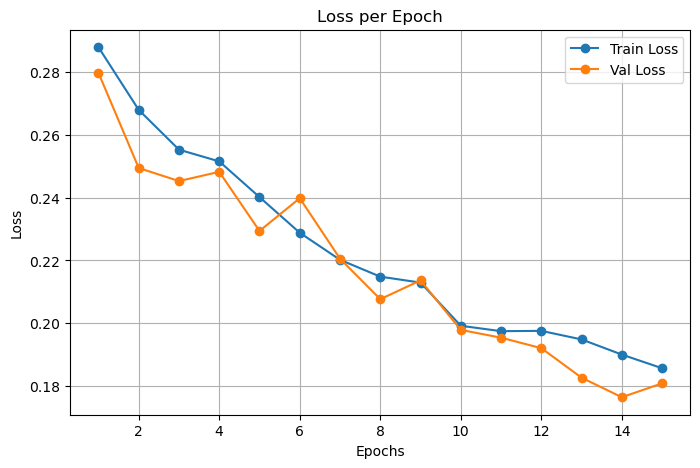

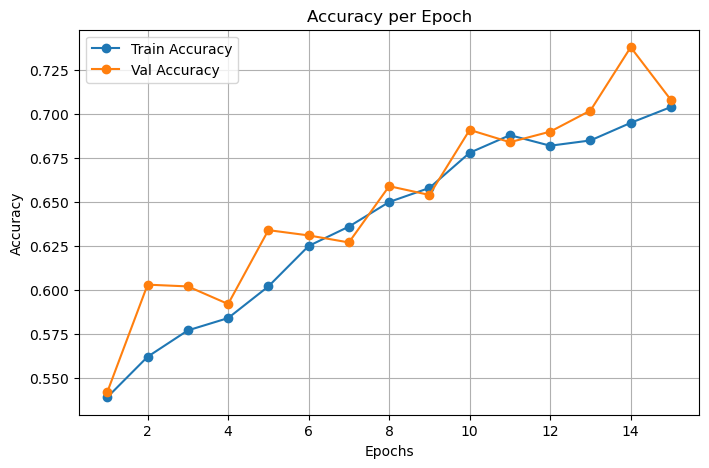

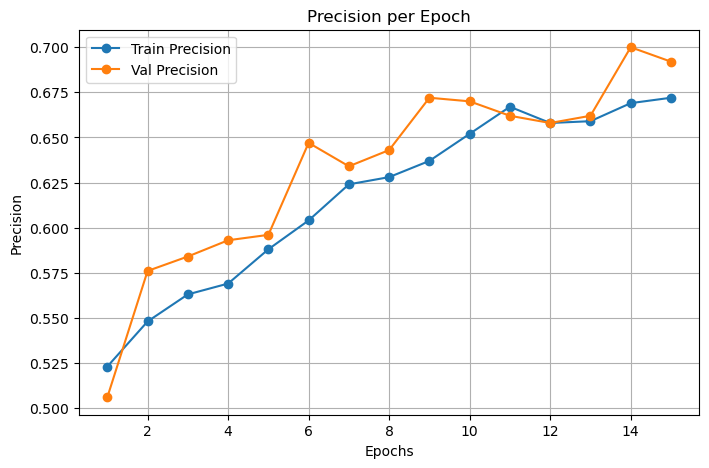

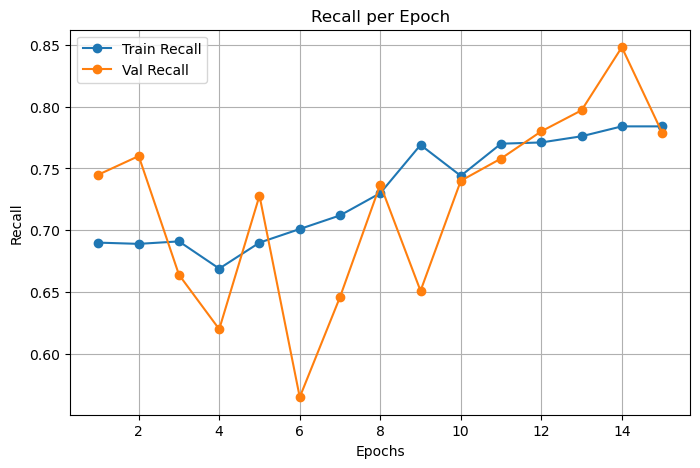

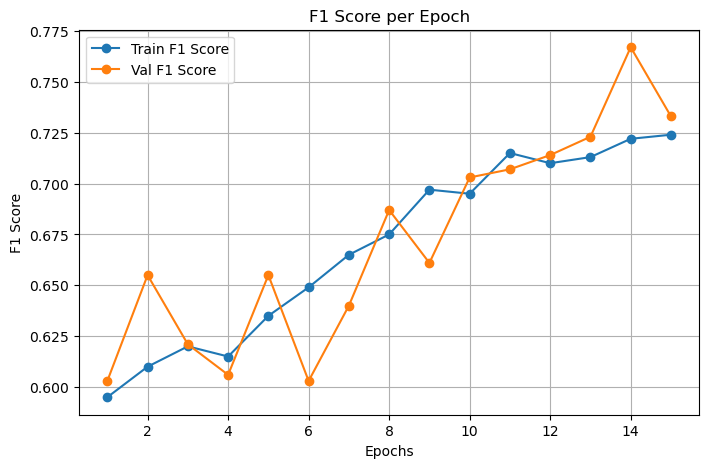

In [50]:
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss", marker="o")
plt.plot(epochs, val_losses, label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_acc, label="Train Accuracy", marker="o")
plt.plot(epochs, val_acc, label="Val Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_prec, label="Train Precision", marker="o")
plt.plot(epochs, val_prec, label="Val Precision", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.title("Precision per Epoch")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_rec, label="Train Recall", marker="o")
plt.plot(epochs, val_rec, label="Val Recall", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Recall")
plt.title("Recall per Epoch")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, train_f1, label="Train F1 Score", marker="o")
plt.plot(epochs, val_f1, label="Val F1 Score", marker="o")
plt.xlabel("Epochs")
plt.ylabel("F1 Score")
plt.title("F1 Score per Epoch")
plt.legend()
plt.grid()
plt.show()


validation to find hyper parameter - Threshold

In [ ]:
model = SiameseNetwork()  # Create model instance
model.load_state_dict(torch.load("weights.pth"))  # Load saved weights
model.to(device)  # Move to GPU if available
model.eval()  # Set to evaluation mode


/home/murtaza/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/murtaza/anaconda3/envs/deep_learning/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SiameseNetwork(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [ ]:
all_distances = []
all_labels = []


with torch.no_grad():
    for img1, img2, label in val_loader:  
        img1, img2 , label= img1.to(device), img2.to(device), label.to(device)
        distance = model(img1, img2)
        
        all_distances.append(distance)
        all_labels.append(label)

# Convert list of tensors into a single tensor
all_distances = torch.cat(all_distances)
all_labels = torch.cat(all_labels)


In [31]:

print(f"Min Distance: {all_distances.min().item():.4f}")
print(f"Max Distance: {all_distances.max().item():.4f}")
print(f"Mean Distance: {all_distances.mean().item():.4f}")
print(f"Median Distance: {torch.median(all_distances):.4f}")

Min Distance: 0.0085
Max Distance: 1.4423
Mean Distance: 0.5153
Median Distance: 0.4957


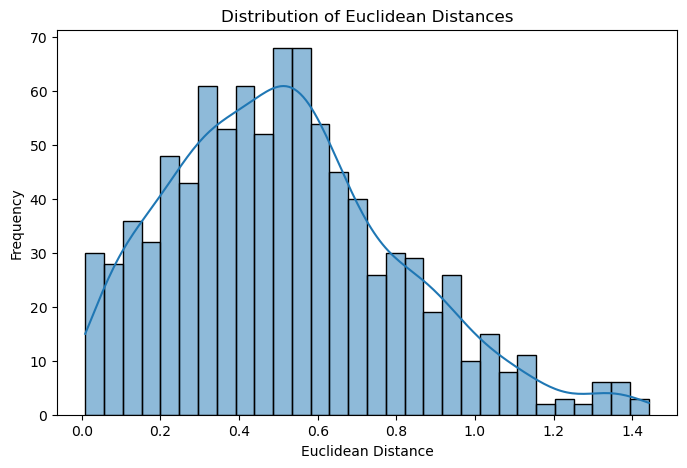

In [32]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(all_distances.cpu().numpy(), bins=30, kde=True)
plt.xlabel("Euclidean Distance")
plt.ylabel("Frequency")
plt.title("Distribution of Euclidean Distances")
plt.show()


In [33]:

def predict_label(d, threshold=0.52): #because mean distance is 0.5142
    return (d < threshold).float()

In [34]:
pred_labels = predict_label(all_distances)

In [35]:
metrics(true_label=all_labels, pred_label=pred_labels)

{'Accuracy': 0.68,
 'Precision': 0.663,
 'Recall': 0.72,
 'F1 Score': 0.69,
 'Confusion Matrix': {'TP': 327, 'TN': 295, 'FP': 166, 'FN': 127}}

In [36]:
classification_rep(all_labels,pred_labels)

'              precision    recall  f1-score   support\n\n         0.0       0.70      0.64      0.67       461\n         1.0       0.66      0.72      0.69       454\n\n    accuracy                           0.68       915\n   macro avg       0.68      0.68      0.68       915\nweighted avg       0.68      0.68      0.68       915\n'

Testing

In [52]:

model = SiameseNetwork()  # Create model instance
model.load_state_dict(torch.load("weights.pth"))  # Load saved weights
model.to(device)  # Move to GPU if available
model.eval()  # Set to evaluation mode


SiameseNetwork(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [65]:
img_path1 = '../caltech-101/BACKGROUND_Google/image_0221.jpg'
img_path2 = '../caltech-101/BACKGROUND_Google/image_0004.jpg'

img1 = Image.open(img_path1).convert("RGB")
img2 = Image.open(img_path2).convert("RGB")

img1 = transform(img1).unsqueeze(0).to(device)  # Add batch dimension and move to device
img2 = transform(img2).unsqueeze(0).to(device)  # Add batch dimension and move to device

with torch.no_grad():
    dist = model(img1,img2)
    lab = predict_label(dist)
    if lab.item():
        print("Same label Images")
    else:
        print("Different label Images")

Same label Images


In [ ]:
test